## Diagnostic Visualizations ##

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gym
from SimpleSAC.sampler import TrajSampler
from SimpleSAC.model import SamplerPolicy, CIFAROneHotPolicy
from SimpleSAC.utils import load_model, load_sac, sequential_head
from models.resnet import ResNet18
import locked_doors.room_world.multiroom
import pickle as pkl
import torch.nn.functional as F
import torch.nn as nn

In [2]:
locked_doors = gym.make('LockedDoorsEnv-v2')
cifar_locked_doors_train4 = gym.make('CIFARLockedDoorsEnvTrain4-v2')
cifar_locked_doors_train100 = gym.make('CIFARLockedDoorsEnvTrain100-v2')
cifar_locked_doors_train1000 = gym.make('CIFARLockedDoorsEnvTrain1000-v2')
cifar_locked_doors_test = gym.make('CIFARLockedDoorsEnvTest-v2')

/media/3tb/chet/miniconda3/envs/SimpleSAC/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def descriptor_to_img(descriptor):
    # CIFAR-10 normalization
    image = np.moveaxis(descriptor, 0, 2)
    mu = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    return image * std + mu
    
def sample_trajectories(policy, eval_env, n_trajs, descriptor_id = None, 
        max_traj_length=100, deterministic=False):
    device = get_device()
    sampler_policy = SamplerPolicy(policy, device)
    traj_sampler = TrajSampler(eval_env, max_traj_length)
    return traj_sampler.sample(sampler_policy, n_trajs, 
        deterministic=deterministic, reset_id=descriptor_id)

def avg_last_is_success(traj_infos):
    return sum(traj_info['is_success'][-1] for traj_info in traj_infos)/len(traj_infos)

def plot_trajectories(trajs, traj_infos, eval_env):
    for traj, traj_info in zip(trajs, traj_infos):
        descriptor_img = descriptor_to_img(traj['observations.descriptor'][0])
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(descriptor_img)
        correct_slot = round(traj_info['correct_slot'][0])
        eval_env.sub_envs[correct_slot].room.draw(ax2)
        ax2.plot(*traj['observations.state'].T, '-o')
        plt.show()

In [5]:
def gen_obs_mesh(eval_env, mesh_size, descriptor):
    descriptors = np.repeat(np.expand_dims(descriptor, 0), mesh_size**2, 0)
    (xlow, ylow), (xhigh, yhigh) = eval_env.room.get_boundary()
    xs = np.linspace(xlow, xhigh, mesh_size + 2)[1:-1]
    ys = np.linspace(ylow, yhigh, mesh_size + 2)[1:-1]
    X, Y = np.meshgrid(xs, ys)
    coords = np.array([X.flatten(), Y.flatten()]).T
    device = get_device()
    return {
        'state': torch.Tensor(coords).to(device),
        'descriptor': torch.Tensor(descriptors).to(device)
    }

def plot_policy(policy, eval_env, mesh_size, descriptor_id):
    env_id, img_idx = descriptor_id
    descriptor = eval_env.dataset[img_idx][0].numpy()
    descriptor_img = descriptor_to_img(descriptor)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.imshow((255*descriptor_img).astype(np.uint8))
    obs_mesh = gen_obs_mesh(eval_env, mesh_size, descriptor)
    states = obs_mesh['state']
    with torch.no_grad():
        actions, _ = policy(obs_mesh, deterministic=True)
    eval_env.sub_envs[env_id].room.draw(ax2)
    ax2.quiver(*(*states.cpu().T, *actions.cpu().T))

def print_class_outputs(policy):
    for i in range(4):
        class_input = F.one_hot(torch.tensor(i), 12).type(torch.FloatTensor)
        print(f'Class {i}:', policy.base_network(class_input))

In [6]:
def plot_q_vals(q_func, policy, eval_env, mesh_size, descriptor_id):
    env_id, img_idx = descriptor_id
    descriptor = eval_env.dataset[img_idx][0].numpy()
    descriptor_img = descriptor_to_img(descriptor)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.imshow(descriptor_img)
    obs_mesh = gen_obs_mesh(eval_env, mesh_size, descriptor)
    states = obs_mesh['state']
    with torch.no_grad():
        actions, _ = policy(obs_mesh, deterministic=True)
        q_vals = q_func(obs_mesh, actions)
    eval_env.sub_envs[env_id].room.draw(ax2)
    ax2.hist2d(*states.cpu().numpy().T, weights=q_vals.cpu().numpy())

### CIFAR 1000 ###

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


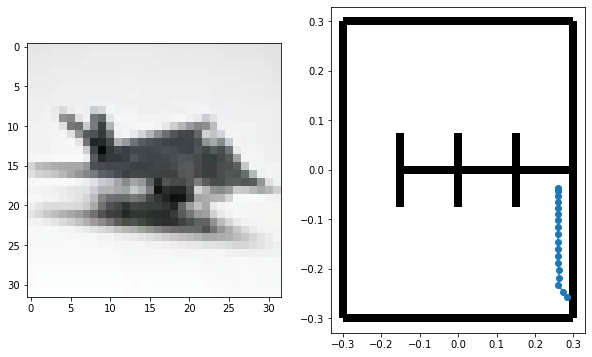

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


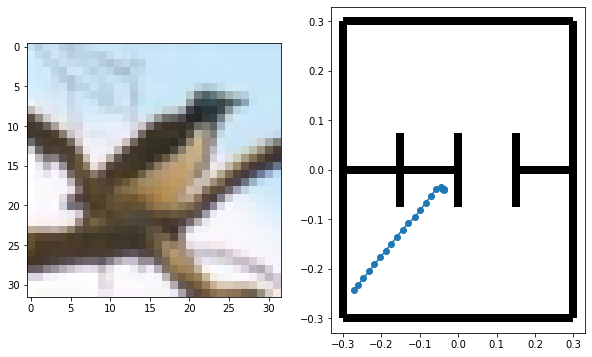

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


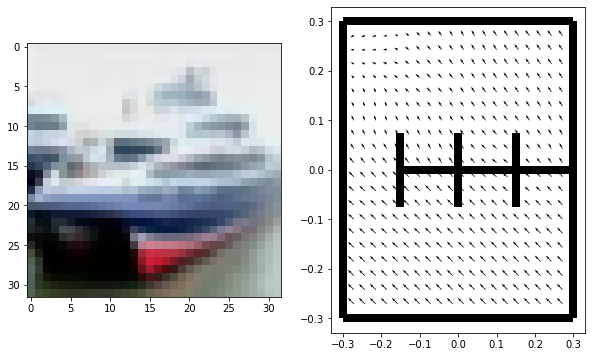

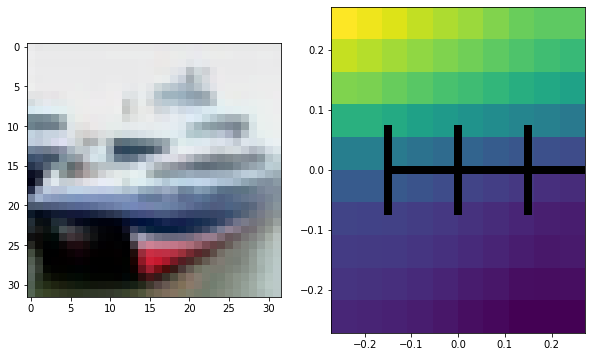

In [7]:
sac = load_sac('/media/3tb/chet/experiment_output/test_sac_cifar1000_20220314_013641/model.pkl')
cifar_1000_policy = sac.policy.to(get_device())
cifar_1000_q_func = sac.qf1.to(get_device())

trajs, traj_infos = sample_trajectories(cifar_1000_policy, cifar_locked_doors_test, 2,
    deterministic=True)

plot_trajectories(trajs, traj_infos, cifar_locked_doors_test)
plot_policy(cifar_1000_policy, cifar_locked_doors_test, 20, (0, 1))
plot_q_vals(cifar_1000_q_func, cifar_1000_policy, cifar_locked_doors_test, 20, (0, 1))

### CIFAR 10000 ###

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


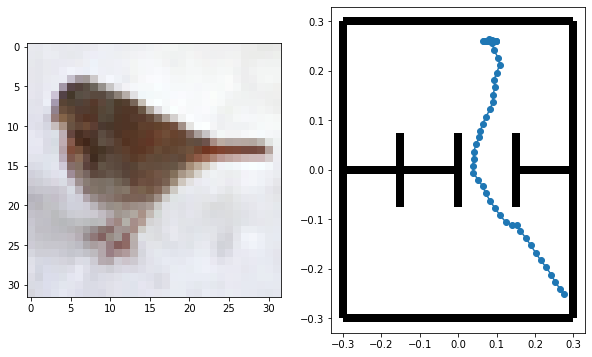

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


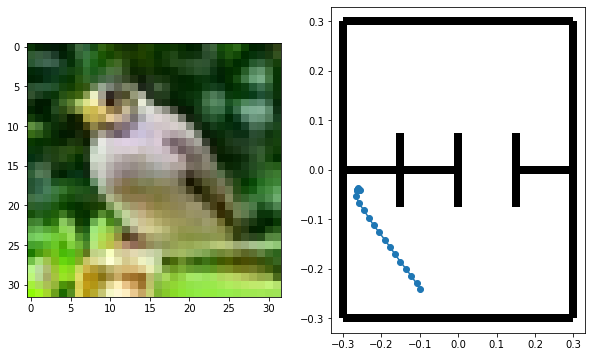

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


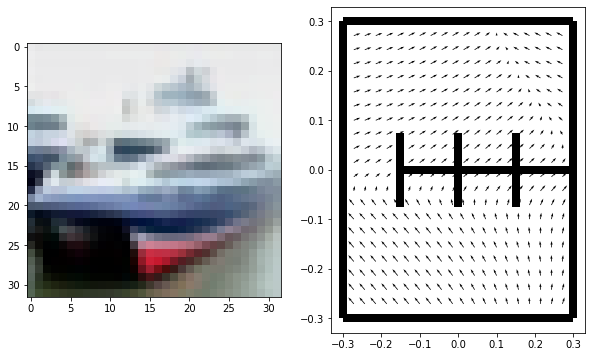

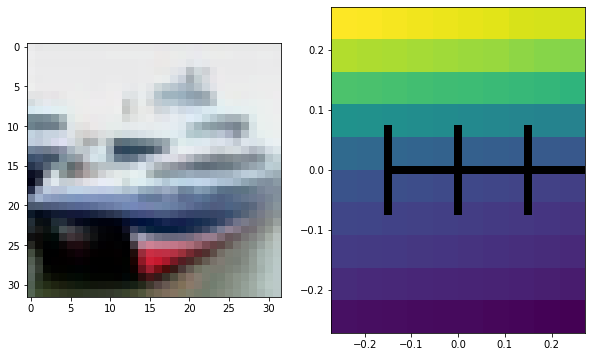

In [8]:
sac = load_sac('/media/3tb/chet/experiment_output/test_sac_cifar10000_20220314_013846/model.pkl')
cifar_10000_policy = sac.policy.to(get_device())
cifar_10000_q_func = sac.qf1.to(get_device())

trajs, traj_infos = sample_trajectories(cifar_10000_policy, cifar_locked_doors_test, 2,
    deterministic=False)

plot_trajectories(trajs, traj_infos, cifar_locked_doors_test)
plot_policy(cifar_10000_policy, cifar_locked_doors_test, 20, (0, 1))
plot_q_vals(cifar_10000_q_func, cifar_10000_policy, cifar_locked_doors_test, 20, (0, 1))

### CIFAR Train ###

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


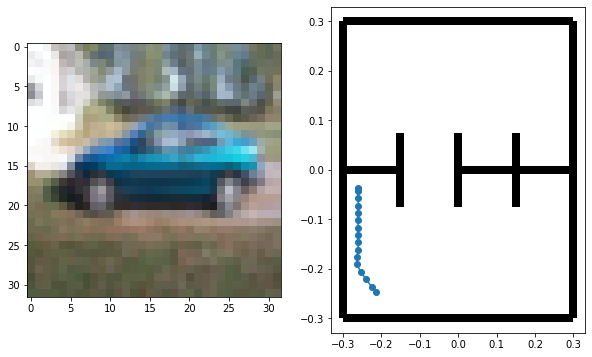

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


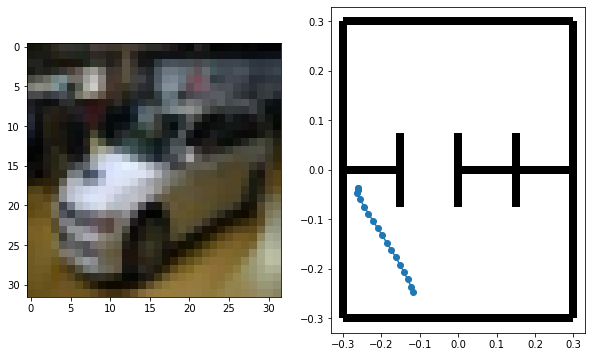

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


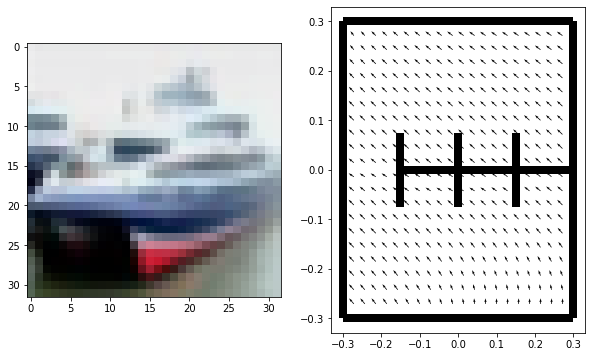

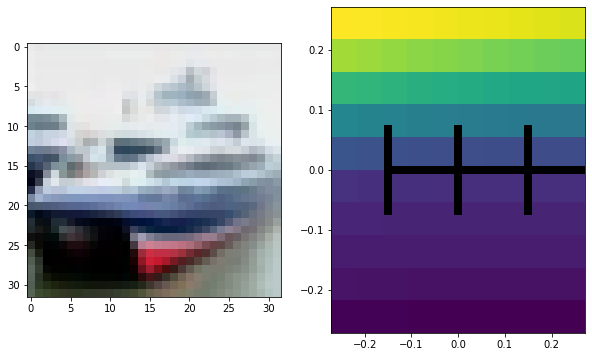

In [9]:
sac = load_sac('/media/3tb/chet/experiment_output/test_sac_cifar_train_20220314_014107/model.pkl')
cifar_train_policy = sac.policy.to(get_device())
cifar_train_q_func = sac.qf1.to(get_device())

trajs, traj_infos = sample_trajectories(cifar_train_policy, cifar_locked_doors_test, 2,
    deterministic=True)

plot_trajectories(trajs, traj_infos, cifar_locked_doors_test)
plot_policy(cifar_train_policy, cifar_locked_doors_test, 20, (0, 1))
plot_q_vals(cifar_train_q_func, cifar_train_policy, cifar_locked_doors_test, 20, (0, 1))


### One Hot ###

#### CIFAR 100 ####

0.31


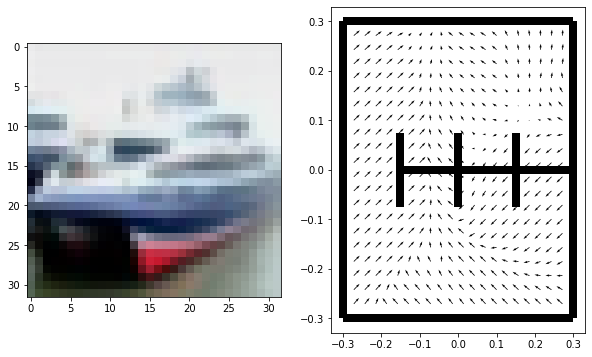

In [10]:
model_path = '/media/3tb/chet/experiment_output/test_sac_locked_doors_20220314_132742/model.pkl'
cifar_path = '/media/3tb/chet/saved_models/sequential_cifar_100_20220404_124914.pkl'
cifar_train_one_hot_policy = CIFAROneHotPolicy(cifar_path, model_path)

with torch.no_grad():
    trajs, traj_infos = sample_trajectories(cifar_train_one_hot_policy, cifar_locked_doors_test, 100,
    deterministic=True)

plot_policy(cifar_train_one_hot_policy, cifar_locked_doors_test, 20, (0, 1))
print(avg_last_is_success(traj_infos))

#### CIFAR 1000 ####

0.59


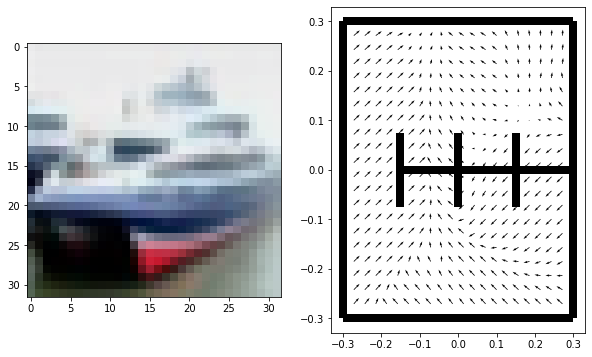

In [11]:
cifar_path = '/media/3tb/chet/saved_models/sequential_cifar_1000_20220404_124922.pkl'
cifar_train_one_hot_policy = CIFAROneHotPolicy(cifar_path, model_path)

with torch.no_grad():
    trajs, traj_infos = sample_trajectories(cifar_train_one_hot_policy, cifar_locked_doors_test, 100,
    deterministic=True)

plot_policy(cifar_train_one_hot_policy, cifar_locked_doors_test, 20, (0, 1))
print(avg_last_is_success(traj_infos))

#### CIFAR 10000 ####

0.63


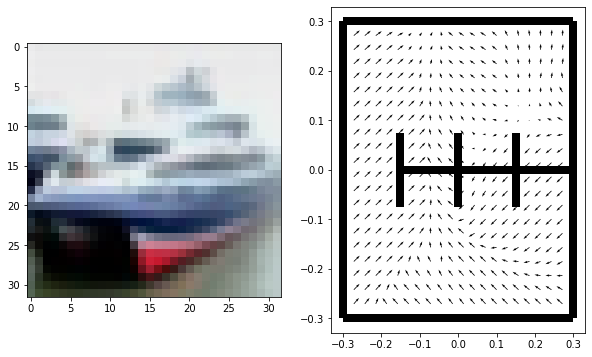

In [12]:
cifar_path = '/media/3tb/chet/saved_models/sequential_cifar_10000_20220404_125003.pkl'
cifar_train_one_hot_policy = CIFAROneHotPolicy(cifar_path, model_path)

with torch.no_grad():
    trajs, traj_infos = sample_trajectories(cifar_train_one_hot_policy, cifar_locked_doors_test, 100,
    deterministic=True)

plot_policy(cifar_train_one_hot_policy, cifar_locked_doors_test, 20, (0, 1))
print(avg_last_is_success(traj_infos))

#### CIFAR Train ####

0.7


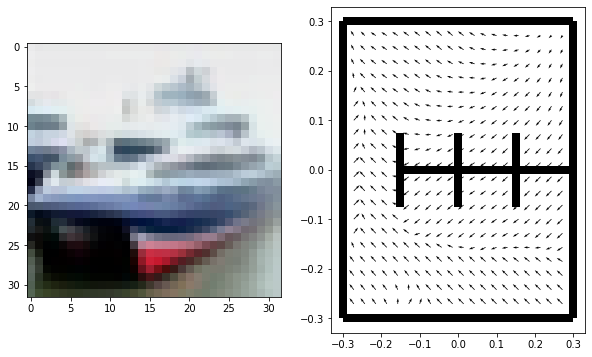

In [13]:
cifar_path = '/media/3tb/chet/saved_models/cifar10_20220314_125839.pkl'
cifar_train_one_hot_policy = CIFAROneHotPolicy(cifar_path, model_path)

with torch.no_grad():
    trajs, traj_infos = sample_trajectories(cifar_train_one_hot_policy, cifar_locked_doors_test, 100,
    deterministic=True)

plot_policy(cifar_train_one_hot_policy, cifar_locked_doors_test, 20, (0, 1))
print(avg_last_is_success(traj_infos))

### Weights and Policies Digging ###

In [14]:
layer_0 = cifar_1000_policy.base_network.network[0]
class_weights = layer_0.weight[:10]
print(class_weights)
print(torch.mean(class_weights))
print(torch.mean(abs(class_weights)))
print(torch.std(class_weights))

tensor([[-0.0990, -0.0106, -0.0183,  0.1899, -0.0994, -0.4437, -0.2144,  0.0958,
          0.0321, -0.1194, -0.1781,  0.9601],
        [-0.3180,  0.0375,  0.0288,  0.2208,  0.0393, -0.0800,  0.1649,  0.0320,
         -0.2764, -0.2320,  0.0856, -0.9813],
        [ 0.1042, -0.2442,  0.1609,  0.2686,  0.0361,  0.1836, -0.2051,  0.0213,
          0.2729,  0.0999, -0.2678,  0.2737],
        [-0.2317, -0.1595, -0.0586, -0.1338, -0.0953,  0.2504, -0.0744,  0.1523,
         -0.0779,  0.0315, -0.2901,  0.2816],
        [ 0.0208, -0.2248,  0.1398,  0.0825, -0.2399, -0.2082,  0.1911,  0.2600,
         -0.0909,  0.0882, -0.8150,  0.4676],
        [-0.2870,  0.1575, -0.1462, -0.1261, -0.1413, -0.2398,  0.3011, -0.2714,
         -0.0452,  0.0690,  0.5539,  1.1023],
        [-0.0884,  0.1036, -0.1131, -0.0873, -0.2765, -0.1040, -0.0716, -0.1482,
         -0.4087, -0.2316, -0.0187, -0.5130],
        [-0.1361,  0.1717, -0.1391, -0.1004, -0.1757, -0.1799, -0.1783, -0.0642,
          0.2728, -0.3058,  0.

### More Training Epochs ###

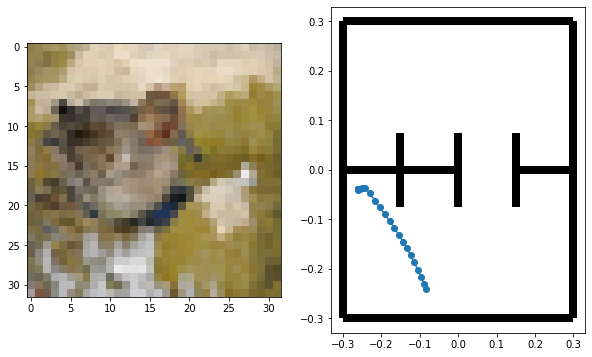

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


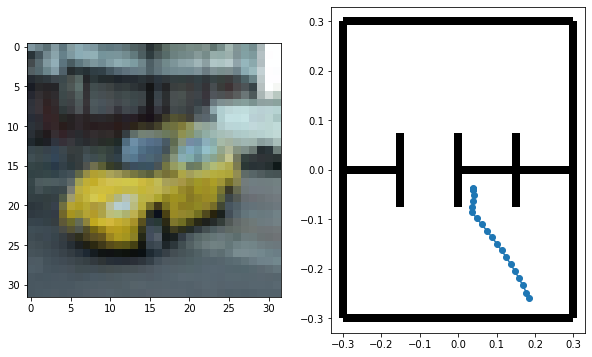

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.1


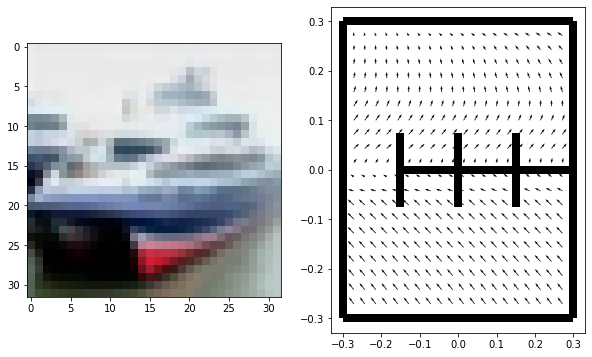

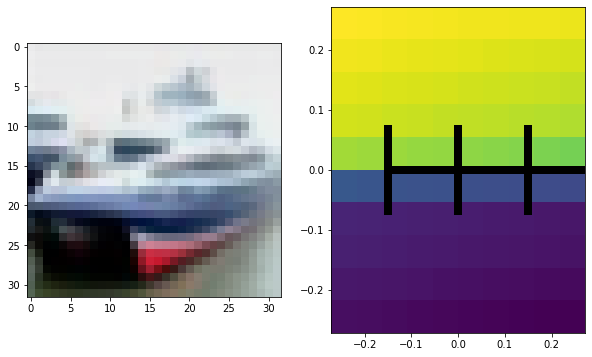

In [15]:
sac = load_sac('/media/3tb/chet/experiment_output/more_epochs_sac_cifar_train_lr3e-5_20220328_170013/model.pkl')
more_epochs_policy = sac.policy.to(get_device())
more_epochs_q_func = sac.qf1.to(get_device())

trajs, traj_infos = sample_trajectories(more_epochs_policy, cifar_locked_doors_test, 2,
    deterministic=True)

plot_trajectories(trajs, traj_infos, cifar_locked_doors_test)
plot_policy(more_epochs_policy, cifar_locked_doors_test, 20, (0, 1))
plot_q_vals(more_epochs_q_func, more_epochs_policy, cifar_locked_doors_test, 20, (0, 1))

trajs, traj_infos = sample_trajectories(more_epochs_policy, cifar_locked_doors_test, 10,
    deterministic=True)
print(avg_last_is_success(traj_infos))

In [16]:
def q_func_snapshots(sacs_path, snapshot_idxs, descriptor_id):
    for idx in snapshot_idxs:
        sac = load_sac(f'{sacs_path}model_epoch_{idx}.pkl')
        q_func = sac.qf1.to(get_device())
        policy = sac.policy.to(get_device())
        plot_q_vals(q_func, policy, cifar_locked_doors_test, 20, descriptor_id)

def policy_snapshots(sacs_path, snapshot_idxs, descriptor_id):
    for idx in snapshot_idxs:
        sac = load_sac(f'{sacs_path}model_epoch_{idx}.pkl')
        policy = sac.policy.to(get_device())
        plot_policy(policy, cifar_locked_doors_test, 20, descriptor_id)

def trajectory_snapshots(sacs_path, snapshot_idxs, descriptor_id):
    for idx in snapshot_idxs:
        sac = load_sac(f'{sacs_path}model_epoch_{idx}.pkl')
        policy = sac.policy.to(get_device())
        trajs, traj_infos = sample_trajectories(policy, cifar_locked_doors_test, 1, deterministic=True)
        plot_trajectories(trajs, traj_infos, cifar_locked_doors_test)


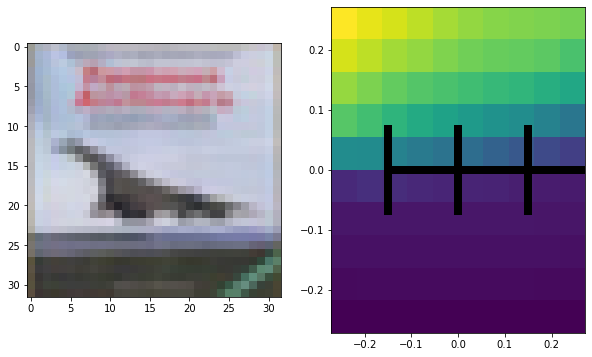

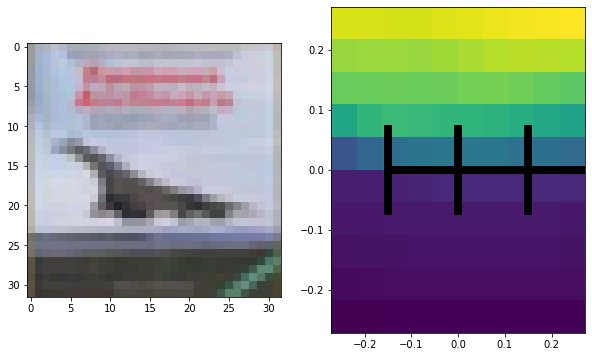

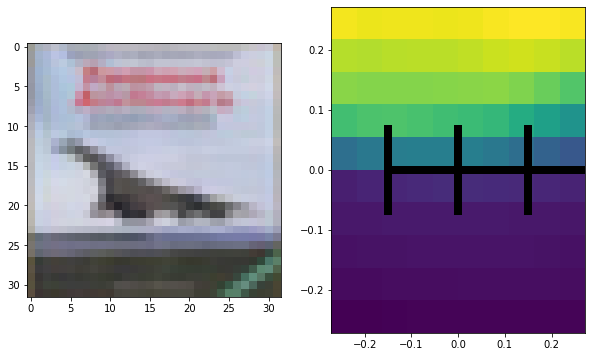

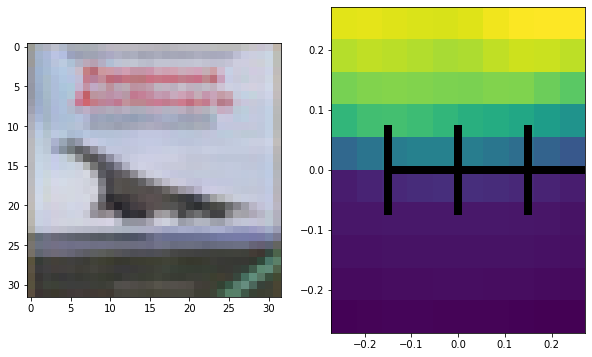

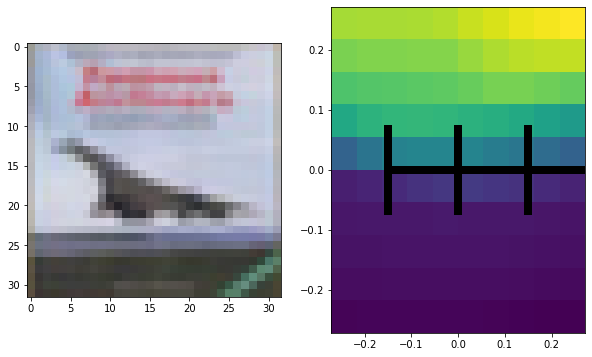

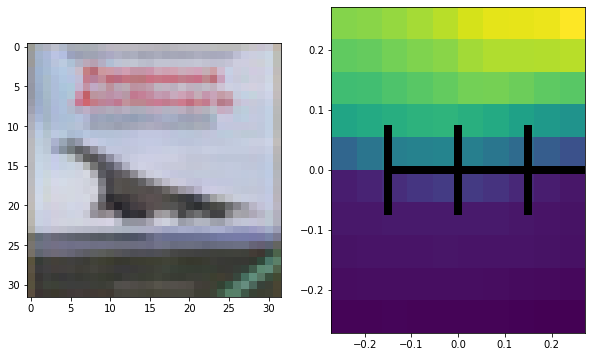

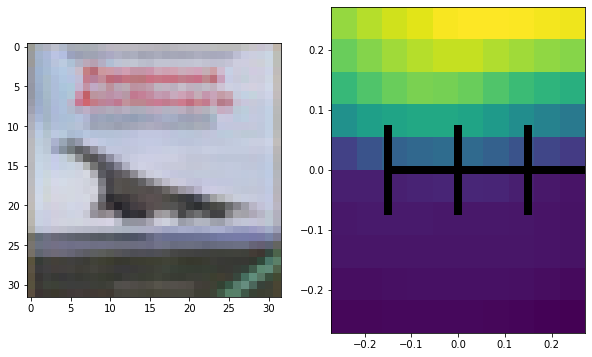

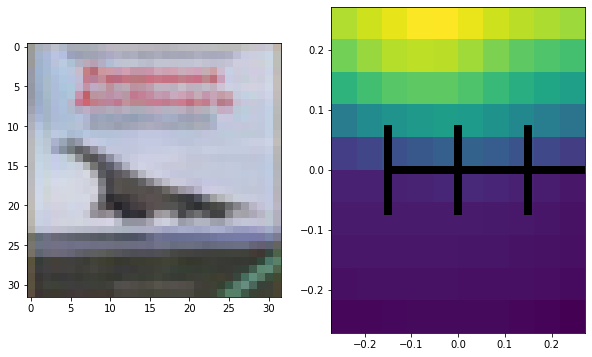

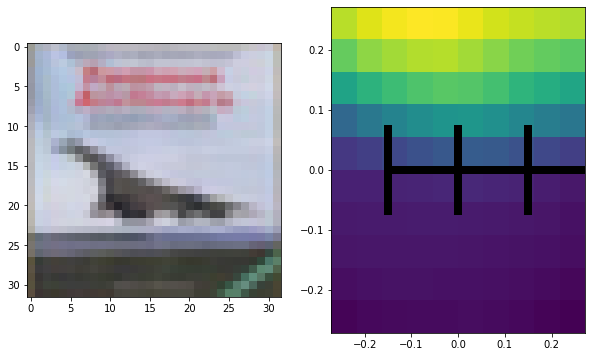

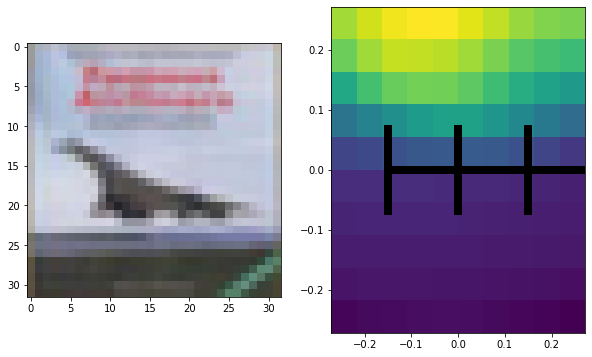

In [17]:
sacs_path='/media/3tb/chet/experiment_output/more_epochs_sac_cifar_train_snapshots_lr3e-4_20220401_180947/'
snapshot_idxs = [*range(401, 500, 10)]
q_func_snapshots(sacs_path, snapshot_idxs, (0, 3))